<a href="https://colab.research.google.com/github/RishabhVenkat/MCS-Healthy-Clustering-with-Pre-processing/blob/main/MCS_Healthy_Clustering_with_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('/content/Combined_new.csv')


In [2]:
# Check for NaNs and Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  # Option 1: Drop rows with NaNs/Infs
# Alternatively, you can fill NaNs with the mean or another value
# df.fillna(df.mean(), inplace=True)

# Assume the first column is time and the rest are EEG channels
stage = df.iloc[:, 0].values
Combined_new = df.iloc[:, 1:].values.T  # Transpose to shape (n_channels, n_samples)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24825 entries, 0 to 24924
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Stage    24825 non-null  object 
 1   Fp1      24825 non-null  float64
 2   Fpz      24825 non-null  float64
 3   Fp2      24825 non-null  float64
 4   F7       24825 non-null  float64
 5   F3       24825 non-null  float64
 6   Fz       24825 non-null  float64
 7   F4       24825 non-null  float64
 8   F8       24825 non-null  float64
 9   T3       24825 non-null  float64
 10  C3       24825 non-null  float64
 11  Cz       24825 non-null  float64
 12  C4       24825 non-null  float64
 13  T4       24825 non-null  float64
 14  T5       24825 non-null  float64
 15  P3       24825 non-null  float64
 16  Pz       24825 non-null  float64
 17  P4       24825 non-null  float64
 18  T6       24825 non-null  float64
 19  O1       24825 non-null  float64
 20  Oz       24825 non-null  float64
 21  O2       24825 no

In [4]:
!pip install mne
import mne

# Create an MNE Info object
sfreq = 1000  # Sample frequency in Hz (adjust based on your data)
ch_names = df.columns[1:].tolist()
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

# Create a RawArray object
raw = mne.io.RawArray(Combined_new, info)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.1 MB/s eta 0:00:00
Creating RawArray with float64 data, n_channels=26, n_times=24825
    Range : 0 ... 24824 =      0.000 ...    24.824 secs
Ready.


In [5]:
# Identify EOG channels
eog_channels = ['VEOG', 'hEOG_bi']
for ch in eog_channels:
    if ch in ch_names:
        info['chs'][ch_names.index(ch)]['kind'] = mne.io.constants.FIFF.FIFFV_EOG_CH
        info['chs'][ch_names.index(ch)]['ch_name'] = ch
        info['ch_names'][ch_names.index(ch)] = ch

In [6]:
# Apply band-pass filter
raw.filter(l_freq=0.5, h_freq=45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,26 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.50 Hz
Lowpass,45.00 Hz


In [7]:
# Using ICA for artifact removal (e.g., eye blinks)
ica = mne.preprocessing.ICA(n_components=20, random_state=97)
ica.fit(raw)

Fitting ICA to data using 26 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,30 iterations on raw data (24825 samples)
ICA components,20
Available PCA components,26
Channel types,eeg
ICA components marked for exclusion,—


In [8]:
# Detecting bad components related to eye blinks
eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name=eog_channels)
ica.exclude = eog_inds  # Mark bad components for exclusion

Using EOG channels: VEOG, hEOG_bi
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [9]:
# Applying ICA to remove artifacts
raw_corrected = ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 26 PCA components


In [10]:
# Re-reference to common average
raw_corrected.set_eeg_reference('average', projection=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,26 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.50 Hz
Lowpass,45.00 Hz


In [11]:
# Create epochs with fixed length
epochs = mne.make_fixed_length_epochs(raw_corrected, duration=5, overlap=1)

Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [12]:
# Convert epochs to NumPy array
epochs_data = epochs.get_data()


Using data from preloaded Raw for 5 events and 5000 original time points ...
0 bad epochs dropped


In [13]:
def concatenate_features(epoch):
    mean = np.mean(epoch, axis=-1)
    std = np.std(epoch, axis=-1)
    ptp = np.ptp(epoch, axis=-1)
    var = np.var(epoch, axis=-1)
    minim = np.min(epoch, axis=-1)
    maxim = np.max(epoch, axis=-1)
    argminim = np.argmin(epoch, axis=-1)
    argmaxim = np.argmax(epoch, axis=-1)
    rms = np.sqrt(np.mean(epoch ** 2, axis=-1))
    abs_diff_signal = np.sum(np.abs(np.diff(epoch, axis=-1)), axis=-1)
    skewness = stats.skew(epoch, axis=-1)
    kurtosis = stats.kurtosis(epoch, axis=-1)
    entropy = -np.sum(epoch * np.log2(epoch + np.finfo(float).eps), axis=-1)

    return np.concatenate((mean, std, ptp, var, minim, maxim, argminim,
                           argmaxim, rms, abs_diff_signal, skewness, kurtosis, entropy), axis=-1)

In [14]:
features = [concatenate_features(epoch) for epoch in epochs_data]
features_array = np.array(features)

<ipython-input-13-c126c80025c7>:14: RuntimeWarning: invalid value encountered in log2
  entropy = -np.sum(epoch * np.log2(epoch + np.finfo(float).eps), axis=-1)


In [15]:
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [16]:
# Perform KMeans clustering
from sklearn.cluster import KMeans

In [17]:
# Impute NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')
features_array_imputed = imputer.fit_transform(features_array)

In [18]:
# Check the shape of the imputed features array
print("Shape of imputed features array:", features_array_imputed.shape)

Shape of imputed features array: (5, 312)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


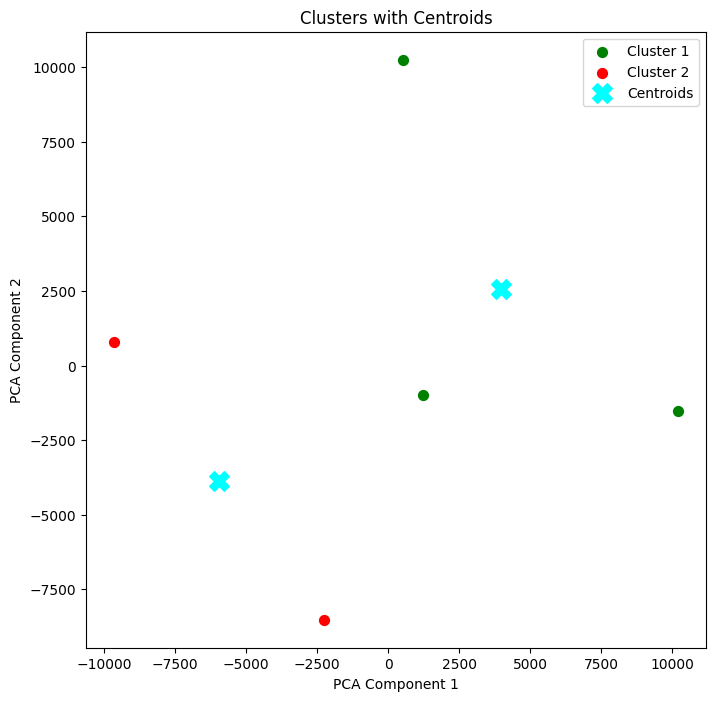

In [19]:
# Perform KMeans clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
Y = kmeans.fit_predict(features_array_imputed)

# Plotting all the clusters and their Centroids

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_array_imputed)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot the clusters in 2D
plt.figure(figsize=(8, 8))
colors = ['green', 'red']
for i in range(n_clusters):
    plt.scatter(X_pca[Y == i, 0], X_pca[Y == i, 1], s=50, c=colors[i % len(colors)], label=f'Cluster {i+1}')

# Plot the centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='cyan', label='Centroids', marker='X')

plt.title('Clusters with Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
